<a href="https://colab.research.google.com/github/Aqsa-K/Sunspots-Activity-Predictions/blob/master/Sunspots_Activity_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install TensorFlow 2.0**

In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 49.7MB/s 
     |████████████████████████████████| 501kB 36.5MB/s 
     |████████████████████████████████| 3.1MB 46.6MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


**Download Sunspot activity data**

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-08-31 09:15:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.31.144, 2404:6800:4004:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.31.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2019-08-31 09:15:20 (138 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



**Function to plot time series data against time**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)


**Load data into lists of time steps and sunspots**

*   convert data to np arrays
*   plot the data   



3235 3235
(3235,) (3235,)


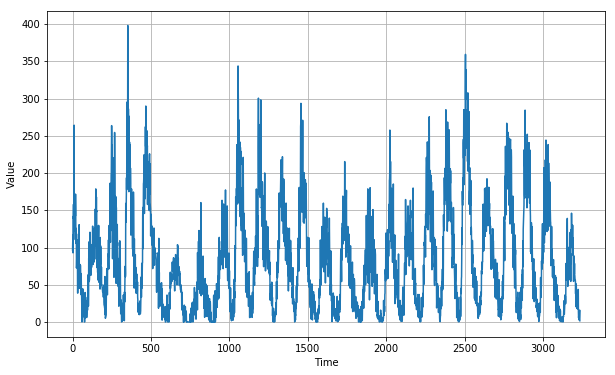

In [13]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

print(len(time_step), len(sunspots))

series = np.array(sunspots)
time = np.array(time_step)

print(time.shape, series.shape)
plt.figure(figsize=(10,6))
plot_series(time, series)

**Split the data into training and testing**

*   total 3500+ activity records
*   3000 in train
*   500+ in test
*   define initial window size as 30
*   define initial batch size as 32
*   define shuffle buffer size as 1000





In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

**Function to take in a series and return windowed data that can be fed in for training**


*   add axis because rnns,lstms etc take 3 input dims
*   convert data to tensor slices
*   create windows from the dataset where the very next value after the window is th epredicted value, drop remainder will make sure we get equal sized windows
*   flatten the dataset keeping the order of data the same
*   shuffle the windowed batches
*   split each sample into respective input and output(predicted), all values except last will be input and the last avlue will be output
*   combine consecutive elements of dataset into batches



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window : (window[:-1], window[1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

**Getting model predictions on a given series data**


*   similar processing is to be applied on test data for prediction as well
*   convert dat to tensor slices
*   combine data into nests of windows
*   flatten out the nested structure keeping the order of data the same
*   get batches of 32 elements each
*   apply prediction
*   return result



In [0]:
def model_forecast(model, series , window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window : window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast


**Model Architecture and Training**


*   clear out the session to prevent any saved model instances from affecting
*   set seed for consistent resutls
*   define window size and batch size
*   get windowed train data
*   define model architecture





In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)




*   A Conv1D layer with 32 filters - causal padding because output at t only depends on less than t values and not values at greater than t
*   LSTM layer with return sequences true because the next layer is also LSTM
*   Another LSTM layer with return sequences false because next layer is a Dense layer
*   A Dense layer with 32 units and relu activation, define input_shape as window size
*   A Dense layer with 10 units and relu activation
*   A Dense layer with 1 unit, by default tanh activation
*   A Lambda layer to scale the output to 400 for better learning with similar scale outputs


**Learning rate Scheduling:**
*   use callback for learning rate scheduling
*   train for 100 epochs and plot learning rate against loss
*   choose a stable learning rate and train with that learning rate for higher number of epochs











In [58]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu'),
                                    tf.keras.layers.LSTM(32, return_sequences=True),
                                    tf.keras.layers.LSTM(32, return_sequences=True),
                                    tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x : x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 6s 133ms/step - loss: 123.8381 - mae: 120.5228
Epoch 2/100
46/46 [==============================] - 3s 63ms/step - loss: 117.4690 - mae: 115.2404
Epoch 3/100
46/46 [==============================] - 3s 64ms/step - loss: 107.2769 - mae: 105.6247
Epoch 4/100
46/46 [==============================] - 3s 64ms/step - loss: 99.1791 - mae: 96.8493
Epoch 5/100
46/46 [==============================] - 3s 63ms/step - loss: 93.2177 - mae: 90.6915
Epoch 6/100
46/46 [==============================] - 3s 63ms/step - loss: 87.6862 - mae: 85.1772
Epoch 7/100
46/46 [==============================] - 3s 64ms/step - loss: 82.0468 - mae: 79.6520
Epoch 8/100
46/46 [==============================] - 3s 64ms/step - loss: 75.8528 - mae: 73.7849
Epoch 9/100
46/46 [==============================] - 3s 64ms/step - loss: 68.1476 - mae: 66.7527
Epoch 10/100
46/46 [==============================] - 3s 64ms/step - loss: 62.1506 - mae: 60.0284
Epoch 11/100
46/46 [==

[1e-08, 0.0001, 0, 60]

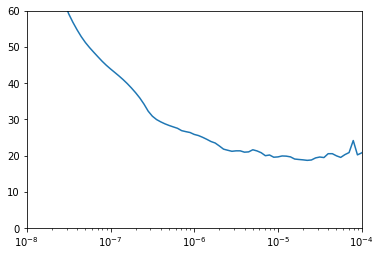

In [59]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8,1e-4,0,60])

Choose 1e-5 as the lr and train again for 500 epochs this time


*   increase batch_size to 100
*   increase lstm units to 60
*   increase filters to 60





In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu'),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x : x*400)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=500, verbose=1)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/500
30/30 [==============================] - 7s 228ms/step - loss: 37.8896 - mae: 47.5943
Epoch 2/500
30/30 [==============================] - 4s 132ms/step - loss: 24.3137 - mae: 26.1555
Epoch 3/500
30/30 [==============================] - 4s 133ms/step - loss: 21.0376 - mae: 21.8694
Epoch 4/500
30/30 [==============================] - 4s 132ms/step - loss: 20.2604 - mae: 20.4014
Epoch 5/500
30/30 [==============================] - 4s 133ms/step - loss: 19.6226 - mae: 19.8699
Epoch 6/500
30/30 [==============================] - 4s 130ms/step - loss: 19.2406 - mae: 19.3127
Epoch 7/500
30/30 [==============================] - 4s 128ms/step - loss: 18.8684 - mae: 19.2343
Epoch 8/500
30/30 [==============================] - 4s 130ms/step - loss: 18.6414 - mae: 18.8004
Epoch 9/500
30/30 [==============================] - 4s 132ms/step - loss: 18.3319 - mae: 18.5803
Epoch 10/500
30/

**Predict on test/val data and plot corresponding graph**

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

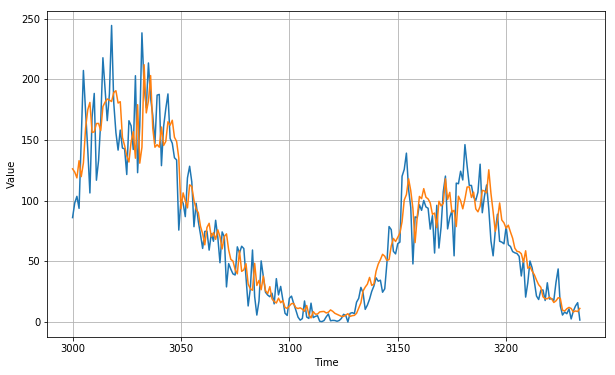

In [69]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [70]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.40074

**Plot Training loss and a zoomed version of training loss in the second half of epochs**

<Figure size 432x288 with 0 Axes>

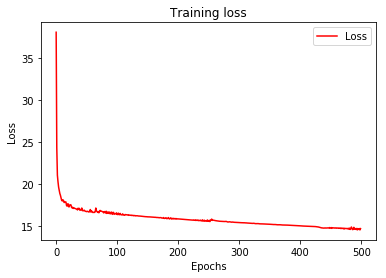

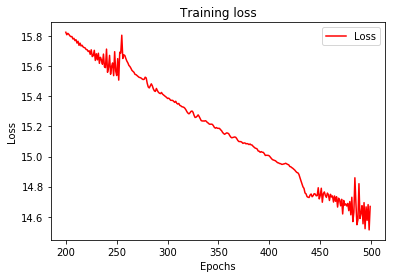

<Figure size 432x288 with 0 Axes>

In [71]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()